In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=[18, 11]

In [2]:
#Create empty class of formulas A2.*
class formulas_A2:
    pass
A2=formulas_A2()# Создаем абсолютно пусто Инстанс (экземпляр) 'A2'

# 1: Calculation of the elastic compliance from ASTM1820 (A2.10 and A2.11)

<img src="photo_2018-10-31_16-04-39.jpg" height="420" width="420"  />

$$
C_{LL(i)}= {\frac 1{E\cdot B_e}}\left(\frac {W+a_i}{W-a_i}\right)^2
\left[
2.1630+12.219\left(\frac {a_i}W\right)
-20.065\left(\frac {a_i}W\right)^2
-0.9925\left(\frac {a_i}W\right)^3
+20.609\left(\frac {a_i}W\right)^4
-9.9314\left(\frac {a_i}W\right)^5
\right]
\qquad(A2.10) 
\\
\\
\boldsymbol{where:} \\
B_e = B-\frac{(B-B_N)^2}B \;mm
\qquad\qquad\qquad\qquad\qquad\qquad(A2.11)
\\
\\
$$
___
$$
B = 20 \;mm \\
B_N = 0.2 \cdot\;B \\
E = 190 000 \;MPa = 190 000 \;\frac N {{mm}^2} \\
W = 40\;mm \\
$$

In [3]:
#Вводим в оборот формулы А2.10 и А2.11
def __(self, ai): #(A2.10)
    #вводим константы для (A2.10)
    self.B= 20.
    self.BN= 0.2*self.B
    self.Be= self.B - (self.B-self.BN)**2/self.B # (A2.11)
    self.E= 190000.
    self.W= 40.
    
    self.ai=ai #?
    ai_w=ai/self.W
    return (2.1630 + 12.219*ai_w - 20.065*ai_w**2 - 0.9925*ai_w**3 + 20.609*ai_w**4 - 9.9314*ai_w**5) * \
        ( (self.W+ai)/(self.W-ai) )**2./(self.E*self.Be)
    #

formulas_A2._10 = __      # добавляем метод в Класс 'formulas_A2'
A2._10(0.151550581328749) # Юзаем метод для уже существующего Инстанса(экземпляра) 'A2' (test)

1.6394295248661302e-06

In [4]:
#Вводим в оборот метод чтения данных и строим интерполяторы
from scipy.interpolate import interp1d

def __(self):
    self.force = np.loadtxt("FORCE_CMOD_calc1.dat", dtype=np.float)
    self.force[:,1]*=2.0
    self.force[:,2]*=2.0
    self.force_interp = interp1d(self.force[:,1],self.force[:,2], bounds_error=False)

    #загружаем, редуцируем и модифицируем "crack-length_calc1.dat"
    crk=[]
    for xx in np.loadtxt("crack-length_calc1.dat", dtype=np.float):
        if xx[1]:
            crk.append([xx[1], self._10(xx[1]+24.)])
    self.crack=np.asarray(crk)

    #интерполяторы редуцированного массива crack
    self.crack_interp = interp1d(self.crack[:,0],self.crack[:,1], bounds_error=False)
    self.crack_cmode_interp = interp1d(self.crack[:,0], self.force[:,1][- len(self.crack): ], bounds_error=False)
    #
formulas_A2.read=__ #добавляем метод в Класс 'formulas_A2'
A2.read() # Юзаем метод для уже существующего Инстанса(экземпляра) 'A2'

# 1a: creation of the plot $\vartriangle$ a vs. calculated compliance (Cc)

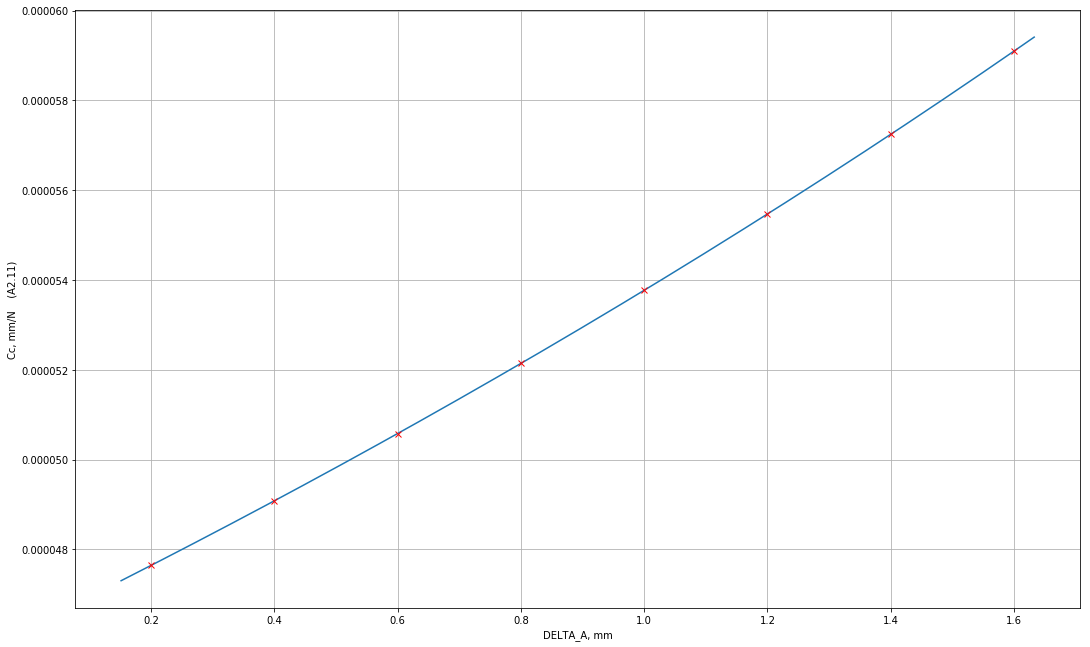

In [5]:
##TEST
# сплошная линия построена по данным массива A2.crack
# контрольные точки построены через функцию-интерполятор массива

plt.rcParams["figure.figsize"]=[18, 11]
plt.plot(A2.crack[:,0],A2.crack[:,1])
plt.xlabel('DELTA_A, mm')
plt.ylabel('Cc, mm/N    (A2.11)')
for _ in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
    plt.plot(_, A2.crack_interp(_), 'rx')
plt.grid()
plt.show()

# 1b: creation of the plot F vs. CMOD from Code_Aster simulation

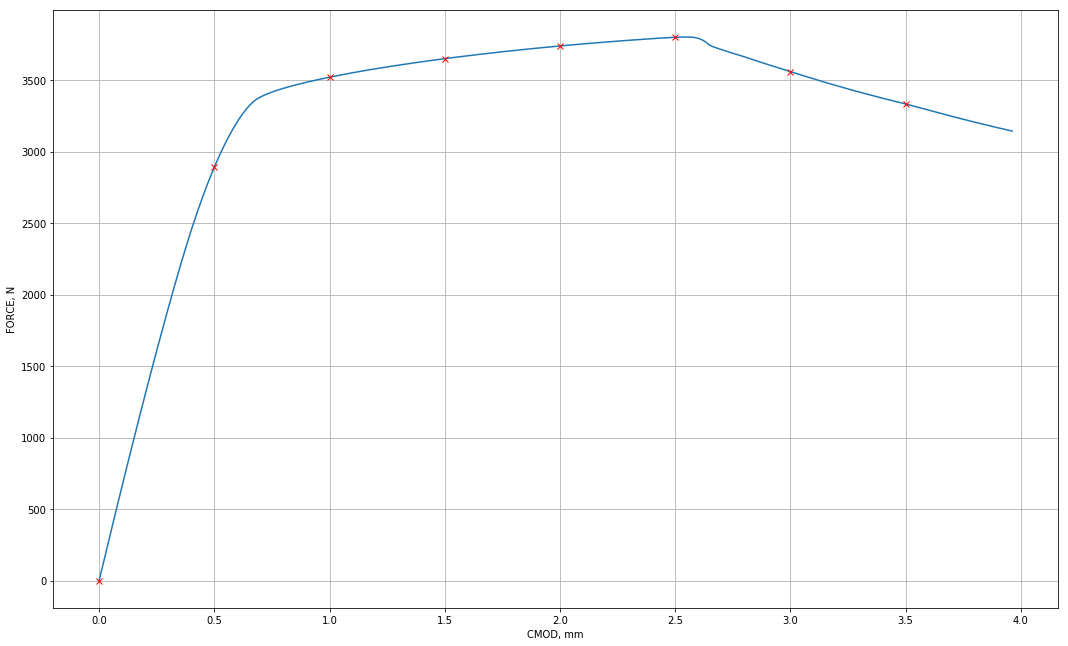

In [6]:
##TEST
# сплошная линия построена по данным массива A2.force
# контрольные точки построены через функцию-интерполятор массива
plt.plot(A2.force[:,1], A2.force[:,2])
plt.xlabel('CMOD, mm')
plt.ylabel('FORCE, N')

for _ in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
    plt.plot(_, A2.force_interp(_), 'rx') # second point
plt.grid()
plt.show()

# 1c: creation of the plot CMOD vs. $\vartriangle$ a 

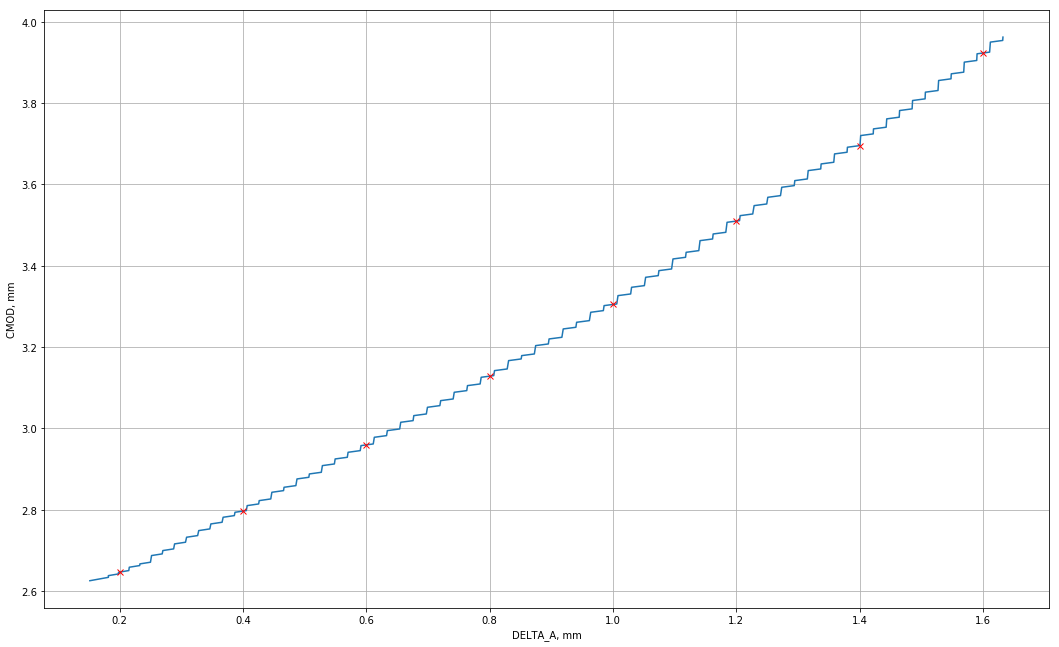

In [7]:
##TEST
plt.plot(A2.crack[:,0], A2.force[:,1][-len(A2.crack) : ])
plt.xlabel('DELTA_A, mm')
plt.ylabel('CMOD, mm')
for _ in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
    plt.plot(_, A2.crack_cmode_interp(_), 'rx') # second point

plt.grid()
plt.show()

In [8]:
from scipy.optimize import fsolve

def __(self, delta):
    cc_ = 1./self.crack_interp(delta).item()
    cmode_ = self.crack_cmode_interp(delta).item()
    self.delta=delta


    x2_ = fsolve(lambda x:A2.force_interp(x) - cc_*(x-cmode_), cmode_)[0]
    y2_ = (x2_ - cmode_) * cc_ 
    
    from scipy.integrate import quad
    self.apl = quad(self.force_interp, self.force[:,1][0], x2_)[0] - y2_ * (x2_ - cmode_) * 0.5
    self.P = y2_

    return (cmode_, x2_, y2_)
    #
formulas_A2.Apl=__  # добавляем метод 'Apl' в class 'formulas_A2'
A2.Apl(1.0), A2.P, A2.apl # юзаем метод 'Apl' в объекте 'A2' (test)

/opt/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


((3.3049594741390784, 3.484496901173944, 3339.0088809079425),
 3339.0088809079425,
 11197.80133515108)

# 1d: creation of the intersection of calculated compliance (Cc) with Force-CMOD curvea and calculation of the Apl

In [9]:
sht=pd.read_excel(pd.ExcelFile('1757-A52.xls'),'Channels by Ste')
sht.iloc[2:,2].values, sht.iloc[2:,1].values

(array([0.000364071, 0.000364071, 0.00218442, ..., 1.16139, 1.1075,
        0.944035], dtype=object),
 array([501.414, 512.303, 538.907, ..., 8642.78, 7248.5, 3013.91],
       dtype=object))

In [21]:
sht=pd.read_excel(pd.ExcelFile('1757-A52.xls'),'Channels by Ste')
xlsm_ = np.transpose(np.asarray((sht.iloc[2:,2].values,sht.iloc[2:,1].values)))

xlsm_,  xlsm_[:,0], xlsm_[:,1]

(array([[0.000364071, 501.414],
        [0.000364071, 512.303],
        [0.00218442, 538.907],
        ...,
        [1.16139, 8642.78],
        [1.1075, 7248.5],
        [0.944035, 3013.91]], dtype=object),
 '',
 array([0.000364071, 0.000364071, 0.00218442, ..., 1.16139, 1.1075,
        0.944035], dtype=object),
 array([501.414, 512.303, 538.907, ..., 8642.78, 7248.5, 3013.91],
       dtype=object))

In [17]:
xlsm_[:,0], xlsm_[:,1]

(array([0.000364071, 0.000364071, 0.00218442, ..., 1.16139, 1.1075,
        0.944035], dtype=object),
 array([501.414, 512.303, 538.907, ..., 8642.78, 7248.5, 3013.91],
       dtype=object))

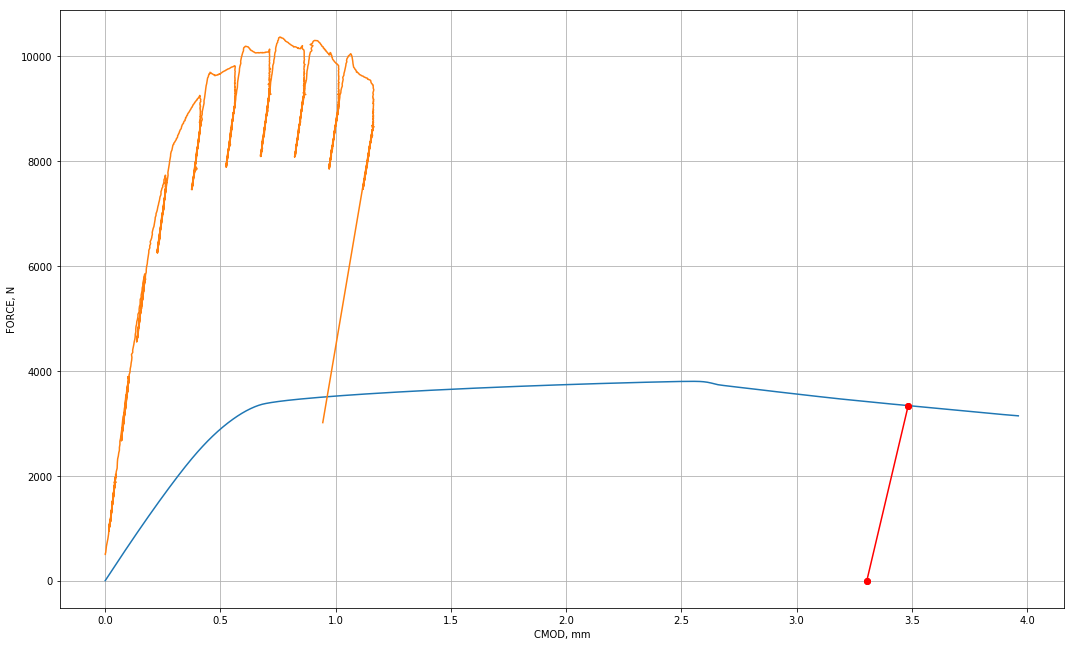

(3.3049594741390784, 3.484496901173944, 3339.0088809079425)

In [23]:
##TEST plt()
plt.plot(A2.force[:,1], A2.force[:,2])
A_= A2.Apl(1.0)

plt.plot(A_[0], 0.0, 'ro') # first point
plt.plot(A_[1], A_[2], 'ro') # second point
plt.plot([A_[0],A_[1]], [0.0, A_[2]], 'ro-')

plt.plot( xlsm_[:,0], xlsm_[:,1])
"""
"""

plt.xlabel('CMOD, mm')
plt.ylabel('FORCE, N')
plt.grid()
plt.rcParams["figure.figsize"]=[18, 11]
plt.show()
A_

# 2a: Calculation of the Jpl according to the ASTM1820 (basic method)

$$
J_{pl(i)}= 
\frac{\eta_{pl} A_{pl}}{B_N b_0}
\qquad(A2.6) 
\\
\boldsymbol{where:} \\
\eta_{pl}=2+0.522\frac{b_{0}}{W}\\
A_{pl} \Longrightarrow 1d \\
b_0=W-a_0 \\
\\
\\
a_0=24 +\vartriangle a \\
B = 20 \;mm \\
B_N = 0.2 \cdot\;B \\
W = 40\;mm \\
$$ 

In [24]:
def __(self): #(A2.6)
    b_0=self.W-self.delta-24.
    self.jpl= (2.+0.522*b_0/self.W)*self.apl/(self.BN*b_0)
    pass
    #
formulas_A2.Jpl = __   # добавляем метод в class 'formulas_A2'
A2.Jpl()               # юзаем метод в объекте 'A2' (test)
A2.jpl  

409.7928713609664

# 2b: Calculation of the Jpl according to the ASTM1820 (incremental version)

$$
J_{pl(i)}= \left[
J_{pl(i-1)}+
\left(
\frac{\eta_{pl(i-1)}}
{b_{(i-1)}}
\right)
{\frac {A_{pl(i)}-A_{pl(i-1)}}{B_N}}
\right]
\left[
1-\gamma_{(i-1)} 
\left(
\frac{a_{(i)}-a_{(i-1)}}{b_{(i-1)}}
\right)
\right] \qquad(A2.8) 
\\
\boldsymbol{where:} \\
\eta_{pl(i-1)}=2+0.522\frac{b_{(i-1)}}{W}
\\
\gamma_{(i-1)}=1.0+0.76\frac{b_{(i-1)}}{W}
A_{pl} \Longrightarrow 1d \\
b_{(i-1)}=W-a_{(i-1)} \\
$$

$$
B = 20 \;mm \\
B_N = 0.2 \cdot\;B \\
W = 40\;mm \\
a_i=24 +\vartriangle a
$$ 

# 3: Calculation of the Jel according to the ASTM1820


$$
J_{el}= {\frac {K^2 (1-\nu^2)}{E}} \qquad(A2.4)
\\
\boldsymbol{where:} \\
\\
K_i= {\frac {P_i}{(B B_N W)^{1/2}}}f \left(\frac {a_i}W\right) \qquad(A2.2) 
\\
f\left(\frac {a_i}W\right) = \frac {\left(2+\frac {a_i}W \right)
\left[0.886 + 4.64 \left(\frac {a_i}W \right)-13.32\left(\frac {a_i}W \right)^2 + 14.72\left(\frac {a_i}W \right)^3-5.6\left(\frac {a_i}W \right)^4
\right]
}{\left(1-\frac {a_i}W \right)^{3/2}} \qquad(A2.3) \\
E=190 000 MPa
$$ 


In [25]:
def __(self):
    self.nu = 0.3
    ai_w=(self.delta+24)/self.W
    fi= ((2.0+ai_w)*(0.886 + 4.64*ai_w - 13.32*ai_w**2 + 14.72*ai_w**3 - 5.6*ai_w**4)) * (1-ai_w)**1.5
    Ki= (self.P * fi /self.B*self.BN*self.W)**0.5
    self.jel= Ki*Ki*(1-self.nu**2)/self.E
    #
formulas_A2.Jel = __

A2.Jel()
A2.jel

0.10196394862567394

# 4: Calculation of the total energy J

$$
J_{total} = J_{pl}+J_{el}
\qquad(A2.5)
$$


In [26]:
def __(self):
    self.total= self.jpl + self.jel
formulas_A2.Jtotal = __

A2.Jtotal()
A2.jpl, A2.jel, A2.total    

(409.7928713609664, 0.10196394862567394, 409.89483530959205)

In [27]:
def __(self, *args):    
    if len(args)==0: # last time
        self.JR=np.asarray(self.JR)
        return     
    if (args[0])==None: # first time 
        self.JR= []
        return
    # next time
    self.Apl(args[0])
    self.Jpl()
    self.Jel()
    self.Jtotal()        
    self.JR.append([self.delta, self.total])
    #
formulas_A2.makeJTotal = __
A2.makeJTotal(None)

In [28]:
##TEST
A2.makeJTotal(None)# init
for _ in [1.0,1.2,1.4,1.6]:
    try:
        A2.makeJTotal(_) #continue
    except:
        continue
A2.makeJTotal()#end

A2.JR

/opt/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([[  1.        , 409.89483531],
       [  1.2       , 440.30116955],
       [  1.4       , 468.49548629],
       [  1.6       , 490.82673542]])

In [29]:
pd.read_excel(pd.ExcelFile('1757-A52.xls'),'GFR')

,"Etude n°1757 ; Prestation n°M6969 : essai J/Δa à 300°C sur la CTJD12,5 repérée 1757-A52",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,"Etude n°1757 ; Prestation n°M6969 : essai J/Δa à 300°C sur la CTJD12,5 repérée 1757-A52.1",Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,déchargement partiel\nn°,Energie U\nGFR\n(N x mm),Δa GFR\n(mm),J (1) GFR\nkJ / m²,J (2) GFR\nkJ / m²,déchargement partiel\nn°,Domaine de validité GFR,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,LN Δa,LN J ( 2 ),Validité pour\nJ ( 2 ),Validité pour Δa
2,1,47.2018,-0.32616,1.05812,1.0813,1 non valide,Déchargements non pris en compte pour le lissage,NaN,oui,non
3,2,219.543,-0.424576,4.92146,5.06219,2 non valide,NaN,NaN,oui,non
4,3,558.734,-0.147233,12.5251,12.6484,3 non valide,NaN,NaN,oui,non
5,4,1178.31,0.00285875,26.414,26.409,4 non valide,NaN,NaN,oui,non
6,5,2466.45,0.000860436,55.2901,55.2869,5 non valide,NaN,NaN,oui,non
7,6,3911.95,0.118551,87.6934,87.0023,6 non valide,NaN,NaN,oui,non
8,7,5408.99,0.153768,121.252,120.014,7 non valide,NaN,NaN,oui,non
9,8,6934.95,0.317985,155.46,152.189,8 Valide,-1.14575,5.02512,oui,oui


In [30]:
sht=pd.read_excel(pd.ExcelFile('1757-A52.xls'),'GFR')
xlsm_ = np.transpose(np.asarray((sht.iloc[2:,2].values,sht.iloc[2:,3].values)))

xlsm_

array([[-0.32615958056186223, 1.0581158936702444],
       [-0.42457618001674113, 4.921463519362556],
       [-0.1472326246484137, 12.525052069766607],
       [0.002858748262484667, 26.414019254526018],
       [0.0008604362991686543, 55.29005577974832],
       [0.11855132620263298, 87.69341658364286],
       [0.1537680199784166, 121.25242070679064],
       [0.3179851941959022, 155.4596291324097],
       [0.5595242297494529, 188.78557582314266],
       [0.7998317463956788, 222.0172415808381],
       [0.8709374999999984, 222.0172415808381]], dtype=object)

In [31]:
A2.makeJTotal(None)
_sheet =[]
for _ in xlsm_:
    if _[0]<A2.crack[:,0][0]:
        continue
    if _[0]>A2.crack[:,0][-1]:
        break
    try:
        A2.makeJTotal(_[0])
        _sheet.append([_[0],_[1]])
        print _
    except:
        continue
A2.makeJTotal()
_sheet = np.asarray(_sheet)        
A2.JR

[0.1537680199784166 121.25242070679064]
[0.3179851941959022 155.4596291324097]
[0.5595242297494529 188.78557582314266]
[0.7998317463956788 222.0172415808381]
[0.8709374999999984 222.0172415808381]


/opt/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


array([[1.53768020e-01, 3.06084723e+02],
       [3.17985194e-01, 3.23104992e+02],
       [5.59524230e-01, 3.52473379e+02],
       [7.99831746e-01, 3.83126467e+02],
       [8.70937500e-01, 3.91590968e+02]])

In [32]:
#EXCLUSION LINE BUILDING:
A2.JRtrend0= np.poly1d(np.polyfit(A2.JR[:,0], A2.JR[:,1], 2)) # исходный тренд

class rootexline:
    def __init__(self,k,trend):
        self.k =k
        self.trend=trend
    def value(self,x1,x):
        return self.k*(x-x1)
    def calc(self,x1):
        xx1=fsolve(lambda x:self.trend(x) - self.value(x1,x), x1)
        return xx1[0],self.value(x1,xx1[0])
#

root0=rootexline(1140,A2.JRtrend0)
roots0=root0.calc(0.15),root0.calc(1.5)

JR0=A2.JR[(A2.JR[:,0] > roots0[0][0])]
JR1=JR0[JR0[:,0]<roots0[1][0]]
A2.JRtrend1= np.poly1d(np.polyfit(JR1[:,0], JR1[:,1], 2)) # урезанный тренд
root1=rootexline(1140,A2.JRtrend1)
roots1=root1.calc(0.2)

print roots0
print JR1
print roots1

((0.44708566956738166, 338.67766330681513), (1.9975876048356693, 567.249869512663))
[[  0.55952423 352.47337934]
 [  0.79983175 383.12646674]
 [  0.8709375  391.59096819]]
(0.5023861099531856, 344.7201653466315)


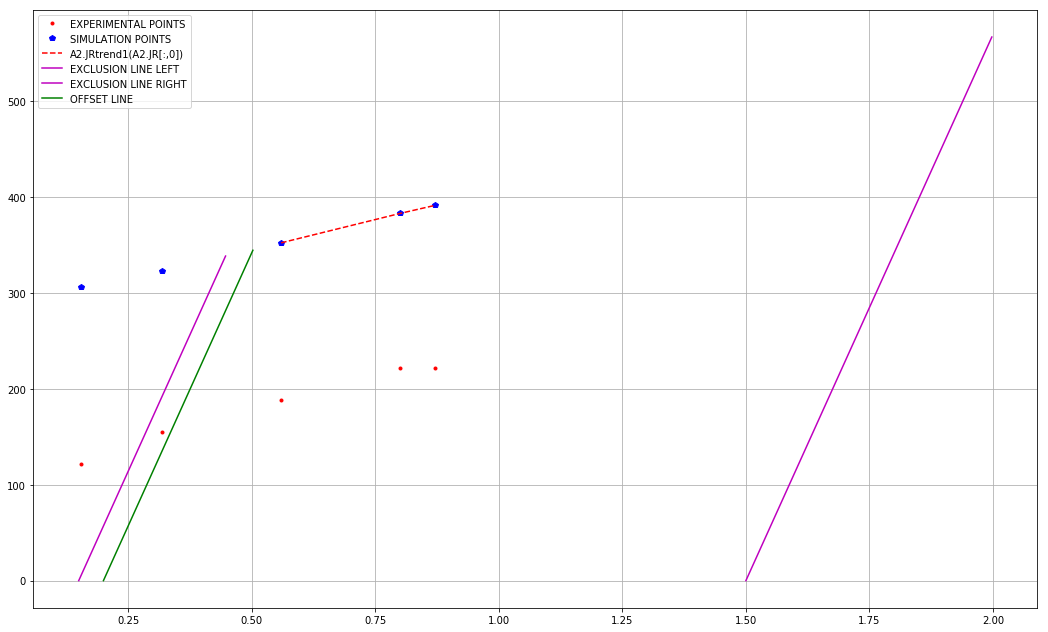

(0.5023861099531856, 344.7201653466315)

In [33]:
##TEST plt()
plt.plot(_sheet[:,0], _sheet[:,1], 'r.')
plt.plot(A2.JR[:,0], A2.JR[:,1], 'bp')
plt.plot(JR1[:,0], A2.JRtrend1(JR1[:,0]), 'r--',)


root0=rootexline(1140,A2.JRtrend0)
xy1=root0.calc(0.15)
plt.plot([0.15,xy1[0]], [0.0, xy1[1]], 'm-')
xy2=root0.calc(1.5)
plt.plot([1.5,xy2[0]], [0.0, xy2[1]], 'm-')

root1=rootexline(1140,A2.JRtrend1)
xy1=root1.calc(0.2)
plt.plot([0.2,xy1[0]], [0.0, xy1[1]], 'g-')


plt.grid()
plt.rcParams["figure.figsize"]=[14, 9.]

plt.legend(('EXPERIMENTAL POINTS','SIMULATION POINTS','A2.JRtrend1(A2.JR[:,0])', \
            'EXCLUSION LINE LEFT','EXCLUSION LINE RIGHT','OFFSET LINE'))
plt.show()
xy1

   # 5: Creation of the J-R curve

Угол наклона Exclusion line: y=1140*x

<img src="J_R_curve.png" height="420" width="620"  />

on the J-R curve we plot:

y: $$J_{total}$$
x: $$ \vartriangle a $$

__________